# Lecture 13 - Basics of Curve Fitting: Bayesian Linear Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')
%matplotlib inline

## Objectives

+ Maximum Posterior Estimate
+ Bayesian Linear Regression
+ The evidence approximation
+ Automatic relevance determination.

## Readings

+ These notes.
+ [Ch. 3 of Bishop, 2006](http://www.amazon.com/Pattern-Recognition-Learning-Information-Statistics/dp/0387310738)
+ [Mathematicalmonk, Bayesian Linear Regression](https://www.youtube.com/watch?v=dtkGq9tdYcI)

Plese see the lecture 12 before you start on this one.
We just repeat some of the code that we developed there.
In particular, we load the essential modules and we redefine the basis function classes.

In [2]:
# Linear Basis
class LinearBasis(object):
    """
    Represents a 1D linear basis.
    """
    def __init__(self):
        self.num_basis = 2 # The number of basis functions
    def __call__(self, x):
        """
        ``x`` should be a 1D array.
        """
        return [1., x[0]]
    
# We need a generic function that computes the design matrix
def compute_design_matrix(X, phi):
    """
    Arguments:
    
    X   -  The observed inputs (1D array)
    phi -  The basis functions.
    """
    num_observations = X.shape[0]
    num_basis = phi.num_basis
    Phi = np.ndarray((num_observations, num_basis))
    for i in range(num_observations):
        Phi[i, :] = phi(X[i, :])
    return Phi


# Here is a class for the polynomials:
class PolynomialBasis(object):
    """
    A set of linear basis functions.
    
    Arguments:
    degree  -  The degree of the polynomial.
    """
    def __init__(self, degree):
        self.degree = degree
        self.num_basis = degree + 1
    def __call__(self, x):
        return np.array([x[0] ** i for i in range(self.degree + 1)])
    
    
class FourierBasis(object):
    """
    A set of linear basis functions.
    
    Arguments:
    num_terms  -  The number of Fourier terms.
    L          -  The period of the function.
    """
    def __init__(self, num_terms, L):
        self.num_terms = num_terms
        self.L = L
        self.num_basis = 2 * num_terms
    def __call__(self, x):
        res = np.ndarray((self.num_basis,))
        for i in range(num_terms):
            res[2 * i] = np.cos(2 * i * np.pi / self.L * x[0])
            res[2 * i + 1] = np.sin(2 * (i+1) * np.pi / self.L * x[0])
        return res
    

class RadialBasisFunctions(object):
    """
    A set of linear basis functions.
    
    Arguments:
    X   -  The centers of the radial basis functions.
    ell -  The assumed lengthscale.
    """
    def __init__(self, X, ell):
        self.X = X
        self.ell = ell
        self.num_basis = X.shape[0]
    def __call__(self, x):
        return np.exp(-.5 * (x - self.X) ** 2 / self.ell ** 2).flatten()
    


class StepFunctionBasis(object):
    """
    A set of step functions.
    
    Arguments:
    X   -  The centers of the step functions.
    """
    def __init__(self, X):
        self.X = X
        self.num_basis = X.shape[0]
    def __call__(self, x):
        res = np.ones((self.num_basis, ))
        res[x < self.X.flatten()] = 0.
        return res

We will use the motorcycle data set of lecture 12.

In [3]:
data = np.loadtxt('motor.dat')
X = data[:, 0][:, None]
Y = data[:, 1]

## Probabilistic Regression - Version 2 (Maximum Posterior Estimate)
+ We wish to model the data using some **fixed** basis/features:
$$
y(\mathbf{x};\mathbf{w}) = \sum_{j=1}^{m} w_{j}\phi_{j}(\mathbf{x}) = \mathbf{w^{T}\boldsymbol{\phi}(\mathbf{x})
}
$$

+ We *model the measurement process* using a **likelihood** function:
$$
\mathbf{y}_{1:n} | \mathbf{x}_{1:n}, \mathbf{w}, \sigma \sim N(\mathbf{w^{T}\boldsymbol{\phi}(\mathbf{x})
}, \sigma^2).
$$

+ We *model the uncertainty in the model parameters* using a **prior**:
$$
\mathbf{w} \sim p(\mathbf{w}).
$$

### Gaussian Prior on the Weights
+ Consider the following **prior** on $\mathbf{w}$:
$$
p(\mathbf{w}|\alpha) = \mathcal{N}\left(\mathbf{w}|\mathbf{0},\alpha^{-1}\mathbf{I}\right) = 
\left(\frac{\alpha}{2\pi}\right)^{\frac{m}{2}}\exp\left\{-\frac{\alpha}{2}\lVert\mathbf{w}\rVert^2\right\}.
$$
+ We say:

> Before we see the data, we beleive that $\mathbf{w}$ must be around zero with a precision of $\alpha$.

### Graphical Representation

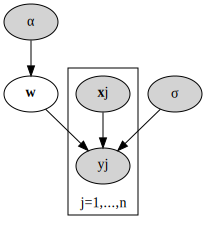

In [4]:
from graphviz import Digraph
g = Digraph('bayes_regression')
g.node('alpha', label='<&alpha;>', style='filled')
g.node('w', label='<<b>w</b>>')
g.node('sigma', label='<&sigma;>', style='filled')
with g.subgraph(name='cluster_0') as sg:
    sg.node('xj', label='<<b>x</b><sub>j</sub>>', style='filled')
    sg.node('yj', label='<y<sub>j</sub>>', style='filled')
    sg.attr(label='j=1,...,n')
    sg.attr(labelloc='b')
g.edge('alpha', 'w')
g.edge('sigma', 'yj')
g.edge('w', 'yj')
g.edge('xj', 'yj')
g.render('bayes_regression', format='png')
g

### The Posterior of the Weights
+ Combining the likelihood and the prior, we get using Bayes rule:
$$
p(\mathbf{w}|\mathbf{x}_{1:n},\mathbf{y}_{1:n}, \sigma,\alpha) = 
\frac{p(\mathbf{y}_{1:n}|\mathbf{x}_{1:n}, \mathbf{w}, \sigma)p(\mathbf{w}|\alpha)}
{\int p(\mathbf{y}_{1:n}|\mathbf{x}_{1:n}, \mathbf{w}', \sigma)p(\mathbf{w}'|\alpha)d\mathbf{w}'}.
$$
+ We say
> The posterior summarizes our state of knowledge about $\mathbf{w}$ after we see the data,
if we know $\alpha$ and $\sigma$.

### Maximum Posterior Estimate
+ We can find a point estimate of $\mathbf{w}$ by solving:
$$
\mathbf{w}_{\mbox{MPE}} = \arg\max_{\mathbf{w}} p(\mathbf{y}_{1:n}|\mathbf{x}_{1:n}, \mathbf{w}, \sigma)p(\mathbf{w}|\alpha).
$$
+ For Gaussian likelihood and weights:
$$
\log p(\mathbf{w}|\mathbf{x}_{1:n},\mathbf{y}_{1:n}, \sigma,\alpha) = 
- \frac{1}{2\sigma^2}\lVert\mathbf{\Phi}\mathbf{w}-\mathbf{y}_{1:n}\rVert^2 -\frac{\alpha}{2}\lVert\mathbf{w}\rVert^2.
$$
+ With maximum:
$$
\mathbf{w}_{\mbox{MPE}} = \left(\sigma^{-2}\mathbf{\Phi}^T\mathbf{\Phi}+\alpha\mathbf{I}\right)^{-1}\mathbf{\Phi}^T\mathbf{y}_{1:n}.
$$
+ But, no analytic formula for $\sigma$...

### The Stable Way to Compute the MAP Estimate
+ Construct the positive-definite matrix:
$$
\mathbf{A} = \left(\sigma^{-2}\mathbf{\Phi}^T\mathbf{\Phi}+\alpha\mathbf{I}\right)
$$
+ Compute the [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition) of $\mathbf{A}$:
$$
\mathbf{A} = \mathbf{L}\mathbf{L}^T,
$$
where $\mathbf{L}$ is lower triangular.
+ Then, solve the system:
$$
\mathbf{L}\mathbf{L}^T\mathbf{w} = \mathbf{\Phi}^T\mathbf{y}_{1:n},
$$
doing a forward and a backward substitution.
+ [scipy.linalg.cho_factor](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.linalg.cho_factor.html#scipy.linalg.cho_factor) and [scipy.linalg.cho_solve](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.linalg.cho_solve.html) can be used for this.

### Radial Basis Functions

In [7]:
import scipy.linalg
ell = 2.
alpha = 20
sigma = 20.28
Xc = np.linspace(0, 60, 20)
phi = RadialBasisFunctions(Xc, ell)
Phi = compute_design_matrix(X, phi)
A = np.dot(Phi.T, Phi) / sigma ** 2. + alpha * np.eye(Phi.shape[1])
L = scipy.linalg.cho_factor(A)
w_MPE = scipy.linalg.cho_solve(L, np.dot(Phi.T, Y))
print('w_MPE:')
print(w_MPE)

w_MPE:
[ -0.08559732  -0.42393506  -0.80250005  -1.34542223  -4.65106566
 -25.23377828 -54.41011189 -60.64451902 -41.55334836  -6.68928764
  12.92364438  13.149271     4.50058993   2.49304068   2.42068378
  -0.89531139  -0.80647722  -0.51200973   0.19383236   0.24279543]


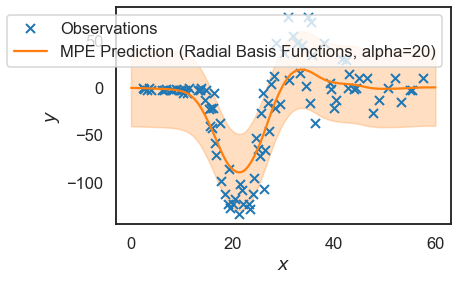

In [9]:
# Let's predict on these points:
X_p = np.linspace(0, 60, 100)[:, None]
Phi_p = compute_design_matrix(X_p, phi)
Y_p = np.dot(Phi_p, w_MPE)
Y_l = Y_p - 2. * sigma # Lower predictive bound
Y_u = Y_p + 2. * sigma # Upper predictive bound
fig, ax = plt.subplots()
ax.plot(X, Y, 'x', markeredgewidth=2, label='Observations')
ax.plot(X_p, Y_p, label='MPE Prediction (Radial Basis Functions, alpha=%1.0f)' % alpha)
ax.fill_between(X_p.flatten(), Y_l, Y_u, color=sns.color_palette()[1], alpha=0.25)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best');

### Questions

+ Experiment with different alphas.
+ When are we underfitting?
+ When are we overfitting?
+ Which one (if any) gives you the best fit?

### Issues with Maximum Posterior Estimate
+ How many basis functions should I use?
+ Which basis functions should I use?
+ How do I pick the parameters of the basis functions, e.g., the lengthscale $\ell$ of the RBFs, $\alpha$, etc.?
+ How do I quantify epistemic uncertainty induced by limited data?

## Probabilistic Regression - Version 3 (Bayesian Linear Regression)
+ For Gaussian likelihood and weights, the posterior is Gaussian:
$$
p(\mathbf{w}|\mathbf{x}_{1:n},\mathbf{y}_{1:n}, \sigma, \alpha) = \mathcal{N}\left(\mathbf{w}|\mathbf{m}, \mathbf{S}\right),
$$
where
$$
\mathbf{S} = \left(\sigma^{-2}\mathbf{\Phi}^T\mathbf{\Phi}+\alpha\mathbf{I}\right)^{-1},
$$
and
$$
\mathbf{m} = \sigma^{-2}\mathbf{S}\Phi^T\mathbf{y}_{1:n}.
$$
+ In general: [Markov Chain Monte Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo).

### Posterior Predictive Distribution
+ Using probability theory, we ask: What do we know about $y$ at a new $\mathbf{x}$ after seeing the data.
+ We have using the sum rule:
$$
p(y|\mathbf{x}, \mathbf{x}_{1:n}, \mathbf{y}_{1:n}, \sigma, \alpha) = 
\int p(y | \mathbf{x}, \mathbf{w}, \sigma) p(\mathbf{w}|\mathbf{x}_{1:n}, \mathbf{y}_{1:n},\sigma,\alpha)d\mathbf{w}.
$$
+ For Gaussian likelihood and prior:
$$
p(y|\mathbf{x}, \mathbf{x}_{1:n}, \mathbf{y}_{1:n}, \sigma, \alpha) = \mathcal{N}\left(y|m(\mathbf{x}), s^2(\mathbf{x})\right),
$$
where
$$
m(\mathbf{x}) = \mathbf{m}^T\boldsymbol{\phi}(\mathbf{x})\;\mbox{and}\;s(\mathbf{x}) = \boldsymbol{\phi}(\mathbf{x})^T\mathbf{S}\boldsymbol{\phi}(\mathbf{x}) + \sigma^2.
$$

### Predictive Uncertainty
+ The **predictive uncertainty** is:
$$
s^2(\mathbf{x}) = \boldsymbol{\phi}(\mathbf{x})^T\mathbf{S}\boldsymbol{\phi}(\mathbf{x}) + \sigma^2.
$$
+ $\sigma^2$ corresponds to the measurement noise.
+ $\boldsymbol{\phi}(\mathbf{x})^T\mathbf{S}\boldsymbol{\phi}(\mathbf{x})$ is the epistemic uncertainty induced by limited data.

In [10]:
import scipy.linalg
ell = 2.
alpha = 0.001
sigma = 20.28
Xc = np.linspace(0, 60, 20)
phi = RadialBasisFunctions(Xc, ell)
Phi = compute_design_matrix(X, phi)
A = np.dot(Phi.T, Phi) / sigma ** 2. + alpha * np.eye(Phi.shape[1])
L = scipy.linalg.cho_factor(A)
m = scipy.linalg.cho_solve(L, np.dot(Phi.T, Y) / sigma ** 2)  # The posterior mean of w
S = scipy.linalg.cho_solve(L, np.eye(Phi.shape[1]))           # The posterior covariance of w
Phi_p = compute_design_matrix(X_p, phi)
Y_p = np.dot(Phi_p, m) # The mean prediction
V_p_ep = np.einsum('ij,jk,ik->i', Phi_p, S, Phi_p) # The epistemic uncertainty
S_p_ep = np.sqrt(V_p_ep)
V_p = V_p_ep + sigma ** 2 # Full uncertainty
S_p = np.sqrt(V_p)
Y_l_ep = Y_p - 2. * S_p_ep  # Lower epistemic predictive bound
Y_u_ep = Y_p + 2. * S_p_ep  # Upper epistemic predictive bound
Y_l = Y_p - 2. * S_p # Lower predictive bound
Y_u = Y_p + 2. * S_p # Upper predictive bound

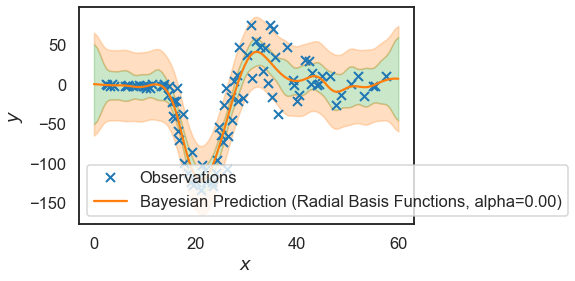

In [11]:
fig, ax = plt.subplots()
ax.plot(X, Y, 'x', markeredgewidth=2, label='Observations')
ax.plot(X_p, Y_p, label='Bayesian Prediction (Radial Basis Functions, alpha=%1.2f)' % alpha)
ax.fill_between(X_p.flatten(), Y_l_ep, Y_u_ep, color=sns.color_palette()[2], alpha=0.25)
ax.fill_between(X_p.flatten(), Y_l, Y_l_ep, color=sns.color_palette()[1], alpha=0.25)
ax.fill_between(X_p.flatten(), Y_u_ep, Y_u, color=sns.color_palette()[1], alpha=0.25)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best');

### Sampling Posterior Models
+ We can actually sample models (functions) from the posterior. Here is how:
    + Sample a $\mathbf{w}$ from $p(\mathbf{w}|\mathbf{x}_{1:n},\mathbf{y}_{1:n}, \sigma, \alpha)$.
    + Look at the sampled model:
    $$
    y(\mathbf{x};\mathbf{w}) = \mathbf{w}^T\boldsymbol{\phi}(\mathbf{x}).
    $$

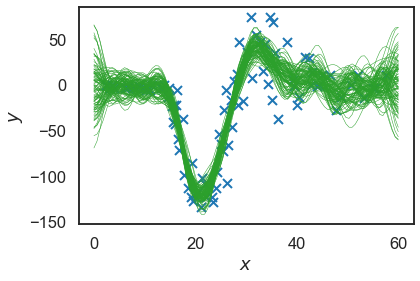

In [13]:
# We have m, S, X_p, and Phi_p from before
fig, ax = plt.subplots()
ax.plot(X, Y, 'x', markeredgewidth=2, label='Observations')
for i in range(100):
    w = np.random.multivariate_normal(m, S)
    Y_p_s = np.dot(Phi_p, w)
    ax.plot(X_p, Y_p_s, color=sns.color_palette()[2], linewidth=0.5);
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

### Questions

+ Experiment with different alphas, ells, and sigmas.
+ When are we underfitting?
+ When are we overfitting?
+ Which one (if any) gives you the best fit?
+ In the figure, right above: Increase the number of posterior $\mathbf{w}$ samples to get a sense of the epistemic uncertainty induced by the limited data.

### Issues with Bayesian Linear Regression
+ How many basis functions should I use?
+ Which basis functions should I use?
+ How do I pick the parameters of the basis functions, e.g., the lengthscale $\ell$ of the RBFs, $\alpha$, etc.?+

## Probabilistic Regression - Version 4 (Hierarchical Priors)
+ So, how do we find all the parameters like $\sigma$, $\alpha$, $\ell$, etc?
+ These are all called **hyper-parameters** of the model.
+ Call all of them
$$
\boldsymbol{\theta} = \{\sigma, \alpha, \ell,\dots\}.
$$

### Hierarchical Priors
+ Model:
$$
y(\mathbf{x};\mathbf{w}) = \sum_{j=1}^{m} w_{j}\phi_{j}(\mathbf{x}) = \mathbf{w^{T}\boldsymbol{\phi}(\mathbf{x})}
$$
+ Likelihood:
$$
\mathbf{y}_{1:n} | \mathbf{x}_{1:n}, \mathbf{w}, \boldsymbol{\theta} \sim p(\mathbf{y}_{1:n}|\mathbf{x}_{1:n}, \mathbf{w}, \boldsymbol{\theta}).
$$
+ Weight prior:
$$
\mathbf{w} | \boldsymbol{\theta} \sim p(\mathbf{w}| \boldsymbol{\theta}).
$$
+ Hyper-prior:
$$
\boldsymbol{\theta} \sim p(\boldsymbol{\theta}).
$$

Graphically:

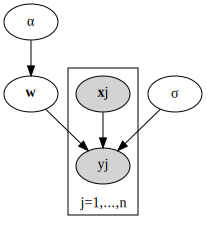

In [14]:
g2 = Digraph('full_bayes_regression_2')
g2.node('alpha', label='<&alpha;>')
g2.node('w', label='<<b>w</b>>')
g2.node('sigma', label='<&sigma;>')
with g2.subgraph(name='cluster_0') as sg:
    sg.node('xj', label='<<b>x</b><sub>j</sub>>', style='filled')
    sg.node('yj', label='<y<sub>j</sub>>', style='filled')
    sg.attr(label='j=1,...,n')
    sg.attr(labelloc='b')
g2.edge('alpha', 'w')
g2.edge('sigma', 'yj')
g2.edge('w', 'yj')
g2.edge('xj', 'yj')
g2.render('full_bayes_regression_2', format='png')
g2

### Fully Bayesian Solution
+ Just write down the posterior of everything:
$$
p(\mathbf{w}, \boldsymbol{\theta}|\mathbf{x}_{1:n}, \mathbf{y}_{1:n}) \propto p(\mathbf{y}_{1:n}|\mathbf{x}_{1:n}|\mathbf{w},\boldsymbol{\theta})p(\mathbf{w}|\boldsymbol{\theta})p(\boldsymbol{\theta}).
$$
+ and, somehow, sample from it...

### The Evidence Approximation
+ Look at the marginal posterior of $\boldsymbol{\theta}$:
$$
p(\boldsymbol{\theta}|\mathbf{x}_{1:n}, \mathbf{y}_{1:n}) \propto 
\int p(\mathbf{y}_{1:n}|\mathbf{x}_{1:n}|\mathbf{w},\boldsymbol{\theta})p(\mathbf{w}|\boldsymbol{\theta})p(\boldsymbol{\theta})d\mathbf{w}.
$$

+ Assume that the hyper-prior is relatively flat:
$$
p(\boldsymbol{\theta}) \propto 1,
$$

+ Use a MAP estimate for $\boldsymbol{\theta}$:
$$
\boldsymbol{\theta}_{\mbox{EV}} = \arg\max_{\boldsymbol{\theta}}\int p(\mathbf{y}_{1:n}|\mathbf{x}_{1:n}|\mathbf{w},\boldsymbol{\theta})p(\mathbf{w}|\boldsymbol{\theta})d\mathbf{w}.
$$

+ Analytical for Gaussian likelihood and prior.

### Implementation Evidence Approximation
+ There is a fast algorithm for the evidence approximation for Bayesian linear regression.
+ It would take about an hour to go over it. See Ch. 3 of (Bishop, 2006).
+ We will use the implementation found in [scikit-learn](http://scikit-learn.org).
+ If you don't have it:
```
conda install scikit-learn
```

### Radial Basis Functions

In [15]:
from sklearn.linear_model import BayesianRidge
ell = 2.
Xc = np.linspace(0, 60, 50)
phi = RadialBasisFunctions(Xc, ell)
Phi = compute_design_matrix(X, phi)
regressor = BayesianRidge()
regressor.fit(Phi, Y)
# They are using different names:
sigma = np.sqrt(1. / regressor.alpha_)
print('best sigma:', sigma)
alpha = regressor.lambda_
print('best alpha:', alpha)
A = np.dot(Phi.T, Phi) / sigma ** 2. + alpha * np.eye(Phi.shape[1])
L = scipy.linalg.cho_factor(A)
m = scipy.linalg.cho_solve(L, np.dot(Phi.T, Y) / sigma ** 2)  # The posterior mean of w
S = scipy.linalg.cho_solve(L, np.eye(Phi.shape[1]))           # The posterior covariance of w
Phi_p = compute_design_matrix(X_p, phi)
Y_p = np.dot(Phi_p, m) # The mean prediction
V_p_ep = np.einsum('ij,jk,ik->i', Phi_p, S, Phi_p) # The epistemic uncertainty
S_p_ep = np.sqrt(V_p_ep)
V_p = V_p_ep + sigma ** 2 # Full uncertainty
S_p = np.sqrt(V_p)
Y_l_ep = Y_p - 2. * S_p_ep  # Lower epistemic predictive bound
Y_u_ep = Y_p + 2. * S_p_ep  # Upper epistemic predictive bound
Y_l = Y_p - 2. * S_p # Lower predictive bound
Y_u = Y_p + 2. * S_p # Upper predictive bound

best sigma: 22.206781585095055
best alpha: 0.0024908742921719513


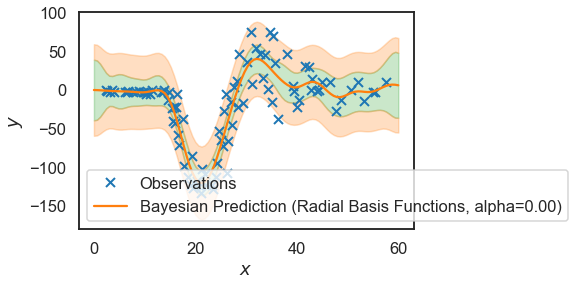

In [16]:
fig, ax = plt.subplots()
ax.plot(X, Y, 'x', markeredgewidth=2, label='Observations')
ax.plot(X_p, Y_p, label='Bayesian Prediction (Radial Basis Functions, alpha=%1.2f)' % alpha)
ax.fill_between(X_p.flatten(), Y_l_ep, Y_u_ep, color=sns.color_palette()[2], alpha=0.25)
ax.fill_between(X_p.flatten(), Y_l, Y_l_ep, color=sns.color_palette()[1], alpha=0.25)
ax.fill_between(X_p.flatten(), Y_u_ep, Y_u, color=sns.color_palette()[1], alpha=0.25)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best');

### Issues with Bayesian Linear Regression with Evidence Approximation
+ How many basis functions should I use?
+ Which basis functions should I use?
+ What if the prior cannot be flat?

### Questions

+ Try the evidence approximation with the Fourier basis.
+ Try the evidence approximation with the Step function basis.

## Probabilistic Regression - Version 5 (Automatic Relevance Determination)
+ Use a different precision $\alpha_i$ for each weight:
$$
p(w_j | \alpha_j) \propto \exp\left\{-\alpha_jw_j^2\right\},
$$
+ so that:
$$
p(\mathbf{w}|\boldsymbol{\alpha}) = \prod_{j=1}^mp(w_j|\alpha_j).
$$

Graphically:

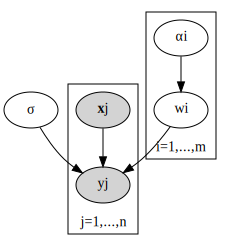

In [17]:
g3 = Digraph('full_bayes_regression_3')
g3.node('sigma', label='<&sigma;>')
with g3.subgraph(name='cluster_0') as sg:
    sg.node('xj', label='<<b>x</b><sub>j</sub>>', style='filled')
    sg.node('yj', label='<y<sub>j</sub>>', style='filled')
    sg.attr(label='j=1,...,n')
    sg.attr(labelloc='b')
with g3.subgraph(name='cluster_1') as sg:
    sg.node('alphai', label='<&alpha;<sub>i</sub>>')
    sg.node('wi', label='<w<sub>i</sub>>')
    sg.attr(label='i=1,...,m')
    sg.attr(labelloc='b')

g3.edge('alphai', 'wi')
g3.edge('sigma', 'yj')
g3.edge('wi', 'yj')
g3.edge('xj', 'yj')
g3.render('full_bayes_regression_3', format='png')
g3

Again, we need advanced techniques to carry out full Bayesian inference.
A quick way out is to maximize the **evidence** with respect to all the $\alpha_j$'s.

### Radial Basis Functions

In [18]:
from sklearn.linear_model import ARDRegression
ell = 2.
Xc = np.linspace(0, 60, 50)
phi = RadialBasisFunctions(Xc, ell)
Phi = compute_design_matrix(X, phi)
regressor = ARDRegression()
regressor.fit(Phi, Y)
# They are using different names:
sigma = np.sqrt(1. / regressor.alpha_)
print('best sigma:', sigma)
alpha = regressor.lambda_
print('best alpha:', alpha)
A = np.dot(Phi.T, Phi) / sigma ** 2. + alpha * np.eye(Phi.shape[1])
L = scipy.linalg.cho_factor(A)
m = scipy.linalg.cho_solve(L, np.dot(Phi.T, Y) / sigma ** 2)  # The posterior mean of w
S = scipy.linalg.cho_solve(L, np.eye(Phi.shape[1]))           # The posterior covariance of w
Phi_p = compute_design_matrix(X_p, phi)
Y_p = np.dot(Phi_p, m) # The mean prediction
V_p_ep = np.einsum('ij,jk,ik->i', Phi_p, S, Phi_p) # The epistemic uncertainty
S_p_ep = np.sqrt(V_p_ep)
V_p = V_p_ep + sigma ** 2 # Full uncertainty
S_p = np.sqrt(V_p)
Y_l_ep = Y_p - 2. * S_p_ep  # Lower epistemic predictive bound
Y_u_ep = Y_p + 2. * S_p_ep  # Upper epistemic predictive bound
Y_l = Y_p - 2. * S_p # Lower predictive bound
Y_u = Y_p + 2. * S_p # Upper predictive bound

best sigma: 21.1802707506458
best alpha: [2.41622694e+01 4.60393723e+01 6.32601940e+01 6.60248705e+01
 6.07577537e+01 6.30419345e+01 6.87983839e+01 7.19885330e+01
 7.47478678e+01 7.18452626e+01 6.67773828e+01 7.04574032e+01
 7.24203099e+01 6.04550341e+01 3.55032689e+01 1.10968067e-03
 1.73367476e-04 1.99589349e+01 2.04616910e+01 1.05969545e-04
 1.86715292e-02 3.14937763e+00 3.87600506e+01 6.61116485e+01
 6.07405331e+01 3.38580108e+01 1.66337169e-03 9.09294119e-04
 2.65807248e+01 3.21594802e+01 2.33882525e+01 3.57257599e+01
 5.45115686e+01 5.24922174e+01 2.87934486e+01 9.11413331e-03
 3.73413978e+01 5.18181885e+01 5.04733546e+01 3.90117514e+01
 3.50099821e+01 4.39235876e+01 4.94959003e+01 5.09197345e+01
 5.16755294e+01 5.22603627e+01 4.72226269e+01 3.69312958e+01
 2.53199918e+01 1.38991944e+01]


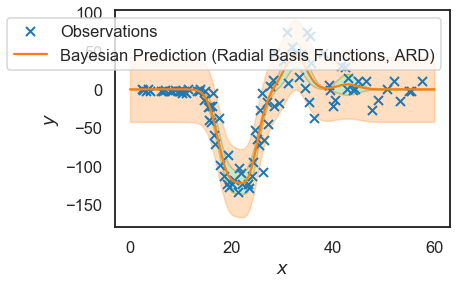

In [19]:
fig, ax = plt.subplots()
ax.plot(X, Y, 'x', markeredgewidth=2, label='Observations')
ax.plot(X_p, Y_p, label='Bayesian Prediction (Radial Basis Functions, ARD)')
ax.fill_between(X_p.flatten(), Y_l_ep, Y_u_ep, color=sns.color_palette()[2], alpha=0.25)
ax.fill_between(X_p.flatten(), Y_l, Y_l_ep, color=sns.color_palette()[1], alpha=0.25)
ax.fill_between(X_p.flatten(), Y_u_ep, Y_u, color=sns.color_palette()[1], alpha=0.25)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best');

### Issues with Automatic Relevance Determination
+ What about the input-dependent (heteroscedastic) noise? We will address this in our Markov Chain Monte Carlo classes.

### Questions

+ Try ARD with the Fourier basis.
+ Try ARD with the Step function basis.
+ Try ARD with a basis that consists both of Fourier and RBFs. Which one's survive?